In [1]:
import sys
sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from sklearn import datasets
from dal_toolbox.active_learning.data import ALDataModule
from dal_toolbox.models.utils.callbacks import MetricsHistory
from dal_toolbox.active_learning.strategies import uncertainty

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


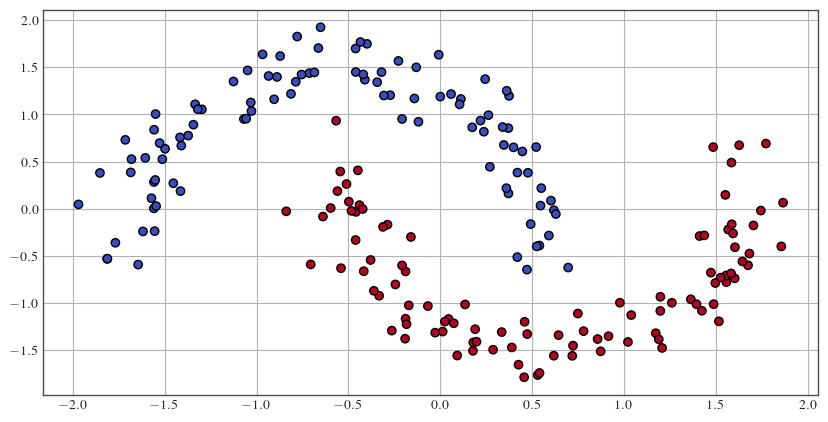

In [2]:
X, y = datasets.make_moons(200, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
# X, y = datasets.make_blobs([20 for _ in range(10)], random_state=12)
y %= 2
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
al_module = ALDataModule(train_ds=train_ds)
al_module.random_init(2, class_balanced=True)
train_loader = al_module.train_dataloader()
next(iter(train_loader))

Using train_dataset for queries. Make sure that there are no augmentations used.


[tensor([[-0.2082,  0.9522],
         [ 0.6177, -1.5617]]),
 tensor([0, 1])]

In [5]:
from dal_toolbox.models.deterministic.base import DeterministicModule

class Net(DeterministicModule):
    def __init__(self, num_classes: int, dropout_rate: int = .2, feature_dim: int = 128,):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_features:
            return out, x
        return out

    @torch.inference_mode()
    def get_probas(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for samples, _ in dataloader:
            logits = self(samples.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        probas = logits.softmax(-1)
        return probas

In [6]:
def dataset_to_xy(dataset):
    X, y = [], []
    for inp, tar in dataset:
        X.append(inp)
        y.append(tar)
    X = torch.stack(X).float()
    y = torch.Tensor(y).long()
    return X, y

@torch.no_grad()
def plot_contour(model, dataset, unlabeled_indices, labeled_indices, ax=None):
    X, y = dataset_to_xy(dataset)

    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], s=1)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=100)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

In [21]:
from dal_toolbox.active_learning.strategies.query import Query
from dal_toolbox.metrics.ood import entropy_from_logits

class EntropySampling(Query):
    def __init__(self, batch_size=64, subset_size=None, device='cuda', random_seed=None):
        super().__init__(random_seed=random_seed)
        self.subset_size = subset_size
        self.batch_size = batch_size
        self.device = device

    @torch.no_grad()
    def query(self, model, trainer, al_datamodule, acq_size, **kwargs):
        logits_list = trainer.predict(model, al_datamodule)
        logits = torch.cat(logits_list)
        scores = entropy_from_logits(logits)
        _, indices = scores.topk(acq_size)

        actual_indices = [al_datamodule.unlabeled_indices[i] for i in indices]
        return actual_indices

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/Documents/projects/uncertainty_evaluation/dal_toolbox/models/deterministic/base.py:24: UserWarning: Using default SGD optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01
).
  return torch.optim.SGD(self.parameters(), lr=1e-1, momentum=.9, weight_decay=0.01)

  | Name           | Type    | Params
------------------------------------

Using train_dataset for queries. Make sure that there are no augmentations used.


/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


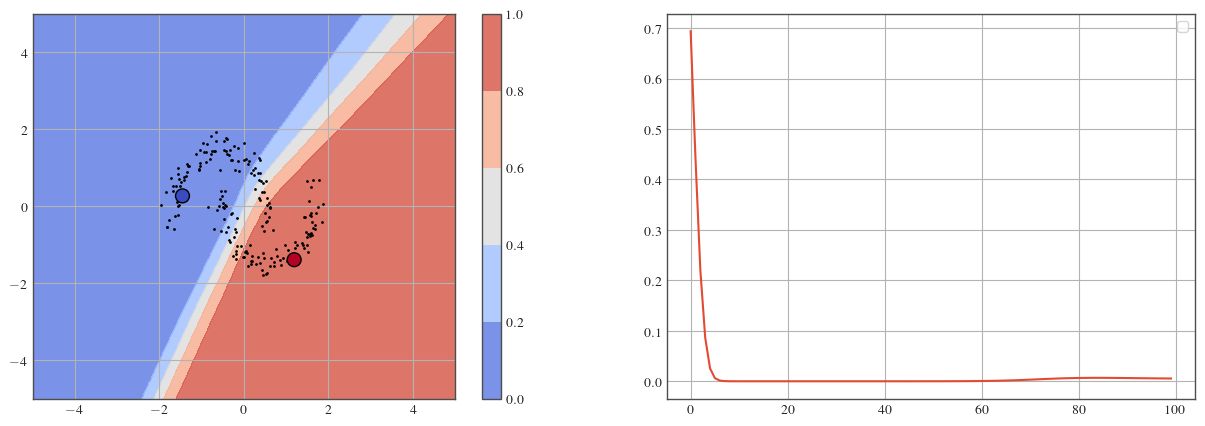

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    

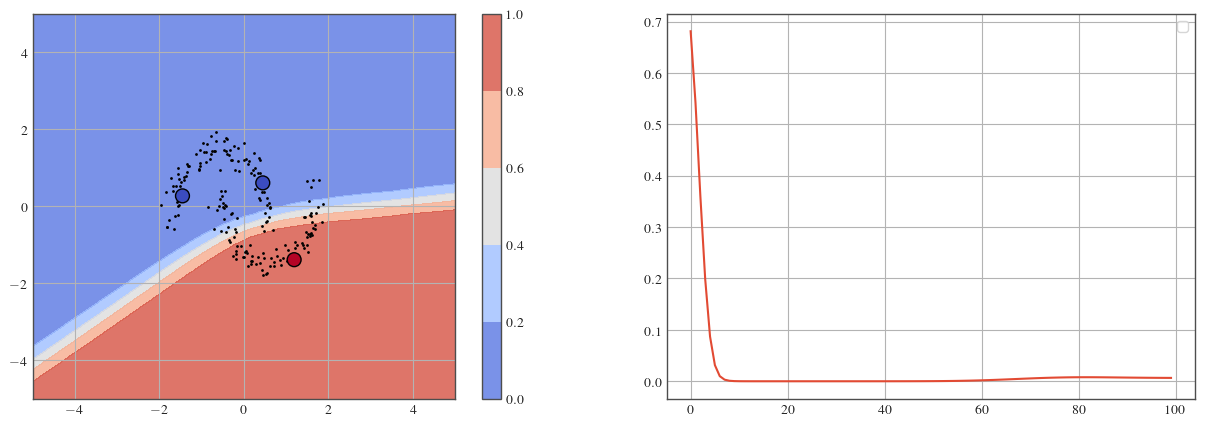

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


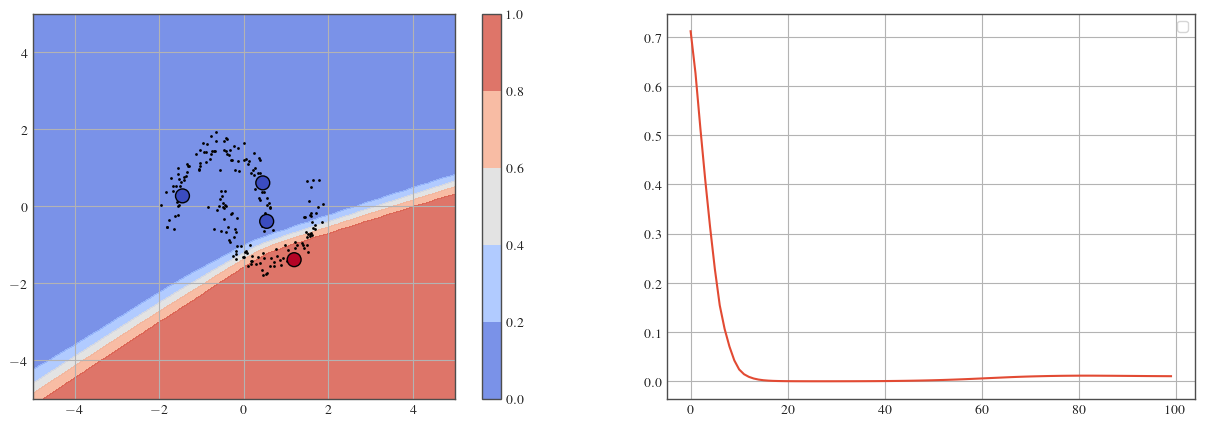

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


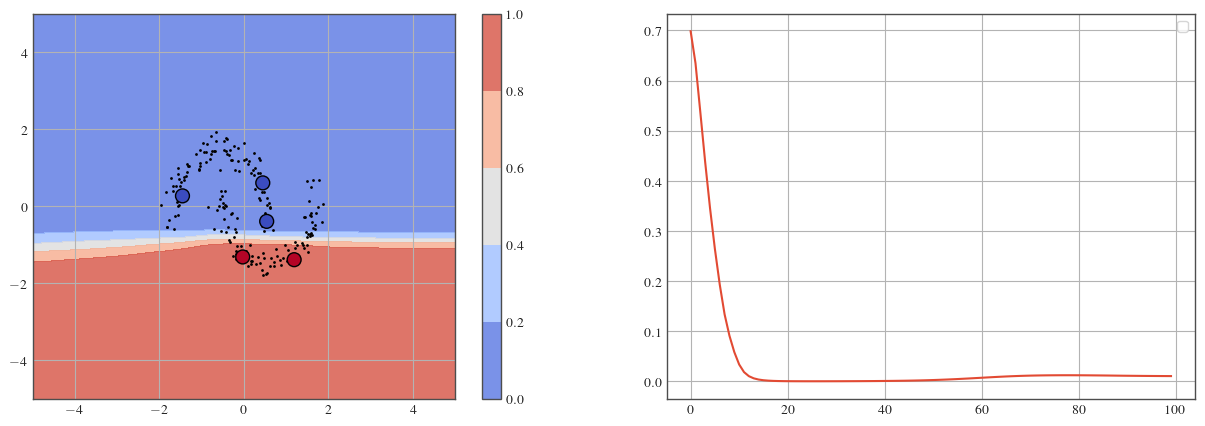

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


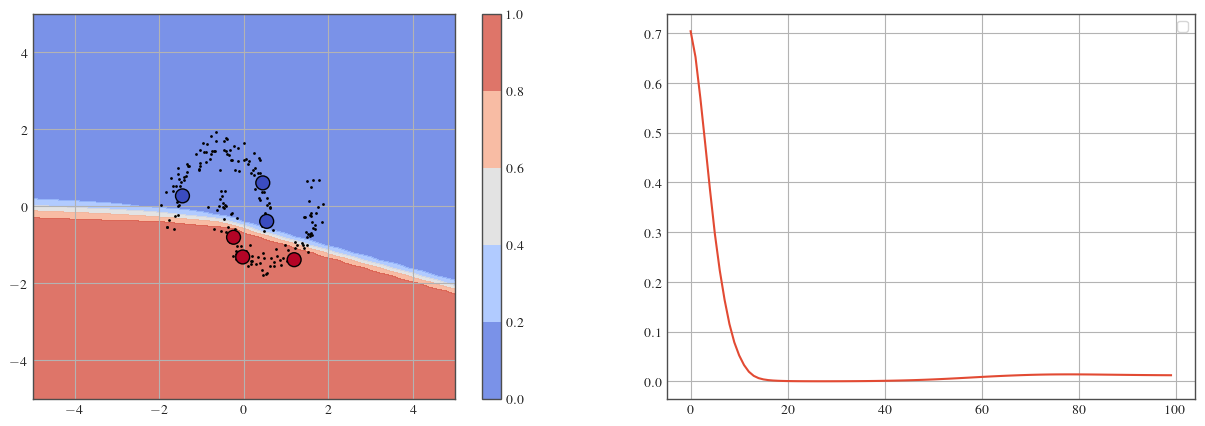

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


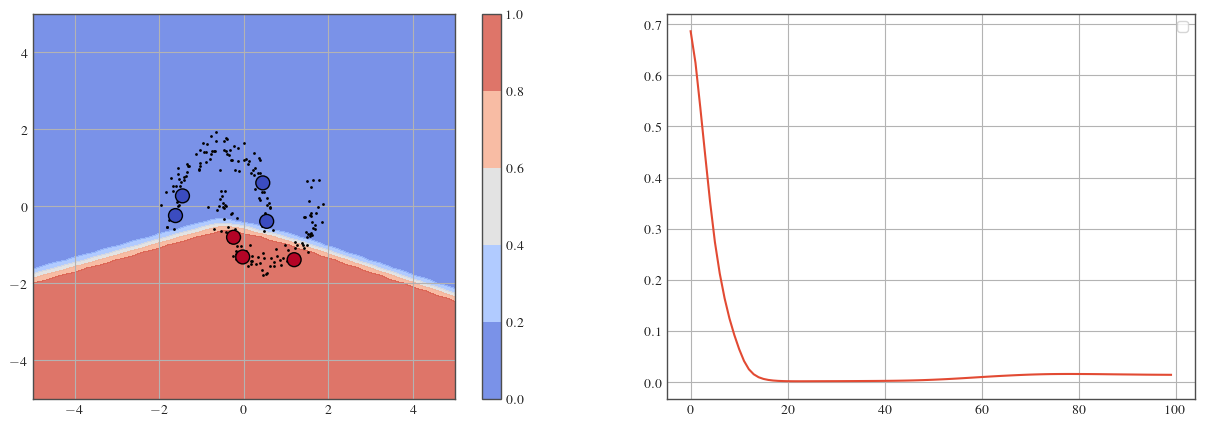

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


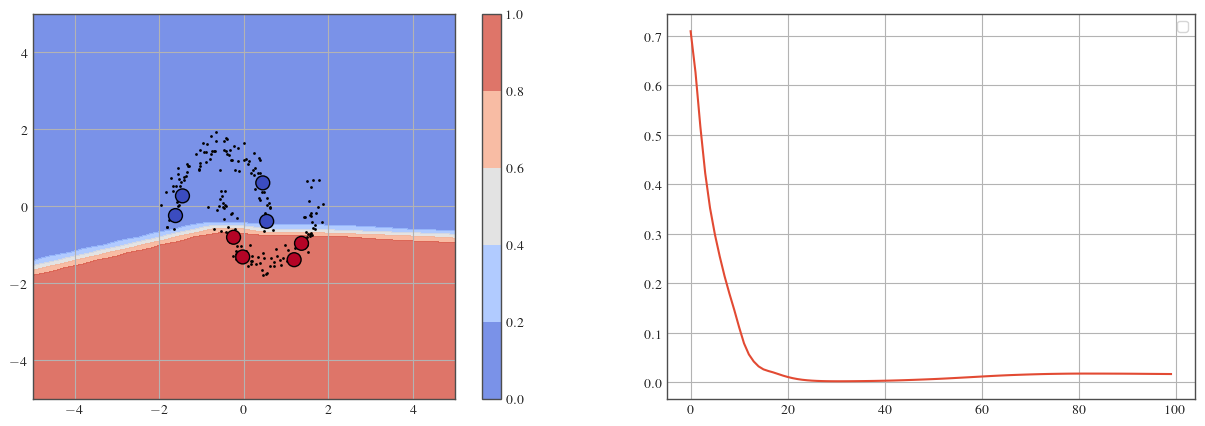

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


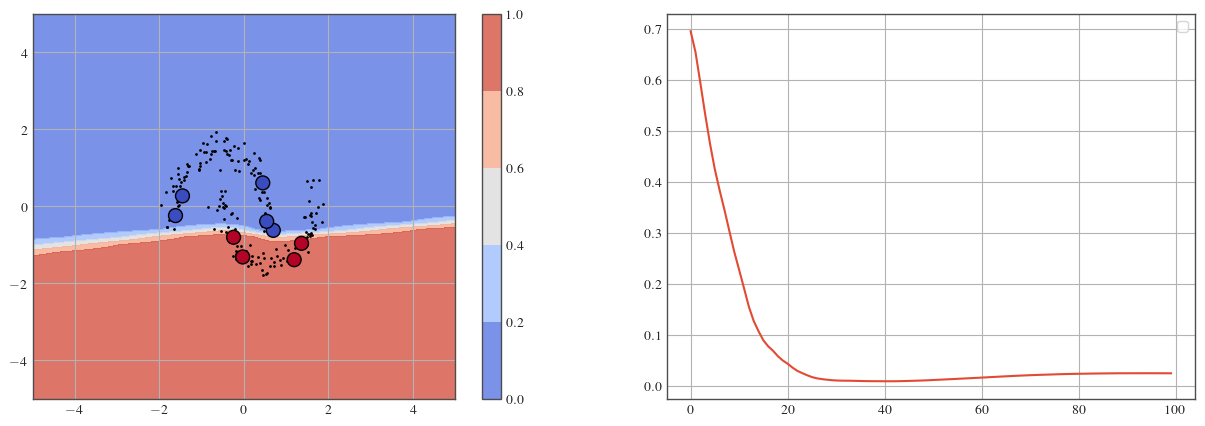

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


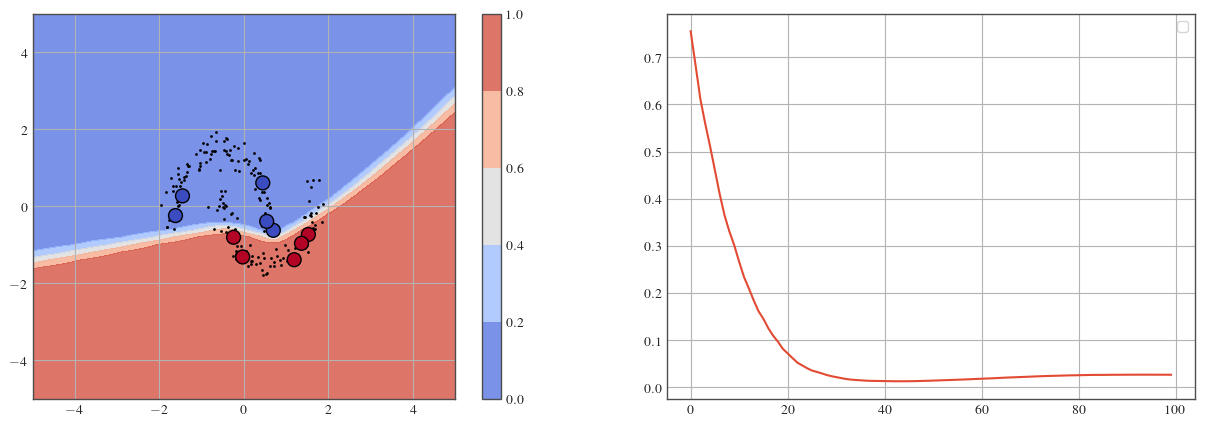

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


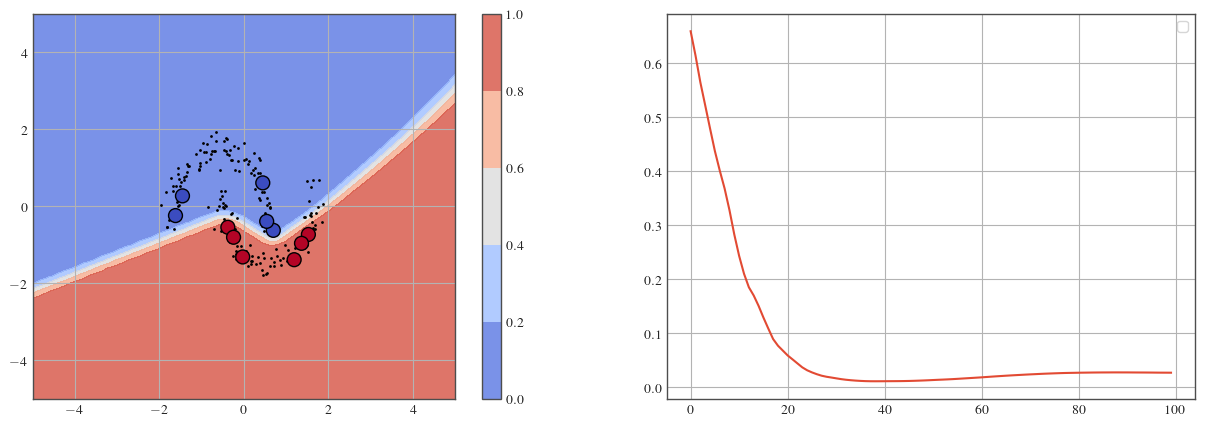

In [22]:
# Train args
np.random.seed(0)
torch.manual_seed(0)
dropout_rate = 0.0
epochs = 100
n_cycles = 10

# AL Setup
al_datamodule = ALDataModule(train_ds)
al_datamodule.random_init(2, class_balanced=True)
# uncertainty_sampling = uncertainty.EntropySampling()
entropy_sampling = EntropySampling()

    
for i_cycle in range(n_cycles):
    if i_cycle != 0:
        entropy_sampling.query(
            model,
            trainer,
            al_datamodule,
            acq_size=1
        )

        logits_list = trainer.predict(model, al_datamodule)
        logits = torch.cat(logits_list)
        entropy = entropy_from_logits(logits)

        _, idx = entropy.topk(1)
        indices = [al_datamodule.unlabeled_indices[idx]]
        al_datamodule.update_annotations(indices)
    
    history = MetricsHistory()
    model = Net(dropout_rate=dropout_rate, num_classes=2)
    trainer = L.Trainer(max_epochs=epochs, callbacks=[history], enable_progress_bar=False)

    trainer.fit(model, al_datamodule)


    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'loss'] for d in history])
    plt.legend()
    plot_contour(model, al_datamodule.query_ds, al_datamodule.unlabeled_indices, al_datamodule.labeled_indices, ax=plt.subplot(121))
    plt.show()